In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import plotly.express as px
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [2]:
# Initialize a Spark session
spark = SparkSession.builder \
    .appName("YelpUserAnalysis") \
    .getOrCreate()

# Load datasets
users_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_user.json")
business_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_business.json")
reviews_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_review.json")
tips_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_tip.json")

# Convert to parquet for better performance
users_df.write.parquet("file:///home/dps/Documents/yelp_dataset/Analysis_Milestone2/users.parquet")
business_df.write.parquet("file:///home/dps/Documents/yelp_dataset/Analysis_Milestone2/business.parquet")
reviews_df.write.parquet("file:///home/dps/Documents/yelp_dataset/Analysis_Milestone2/reviews.parquet")
tips_df.write.parquet("file:///home/dps/Documents/yelp_dataset/Analysis_Milestone2/tips.parquet")

24/11/24 11:34:27 WARN Utils: Your hostname, yelp resolves to a loopback address: 127.0.1.1; using 192.168.64.2 instead (on interface enp0s1)
24/11/24 11:34:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/24 11:34:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/24 11:34:42 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [3]:
# Create temporary views
users_df.createOrReplaceTempView("users")
business_df.createOrReplaceTempView("business")
reviews_df.createOrReplaceTempView("reviews")
tips_df.createOrReplaceTempView("tips")

In [4]:
# Filter Arizona restaurants and create base dataset
base_query = """
WITH az_restaurants AS (
    SELECT business_id, name, city, stars as business_stars, review_count
    FROM business
    WHERE state = 'AZ' 
    AND categories LIKE '%Restaurants%'
),
az_reviews AS (
    SELECT r.*, b.city, b.business_stars
    FROM reviews r
    JOIN az_restaurants b ON r.business_id = b.business_id
)
SELECT DISTINCT u.*
FROM users u
JOIN az_reviews r ON u.user_id = r.user_id
"""

az_users = spark.sql(base_query)
az_users.createOrReplaceTempView("az_users")

## Query 1 - User Activity Distribution in Arizona

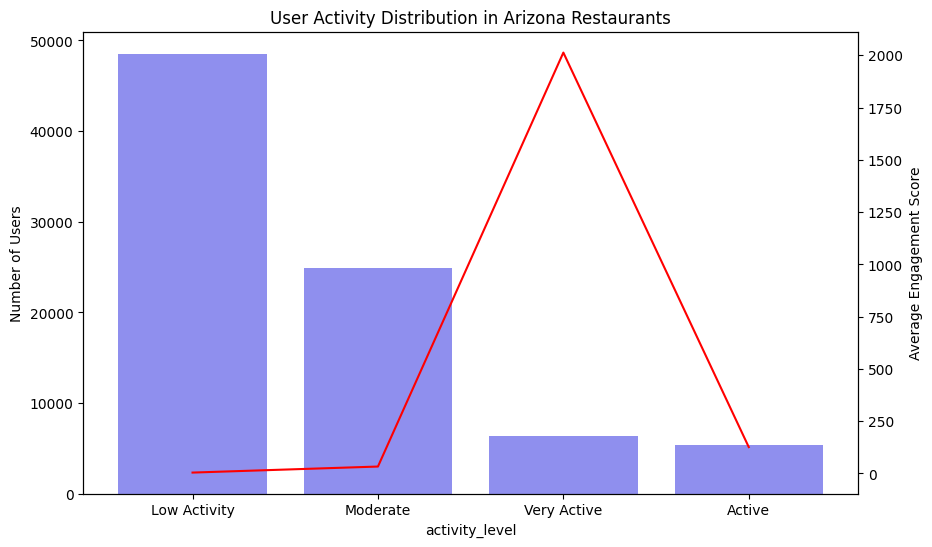

In [6]:
query1 = """
SELECT 
    CASE 
        WHEN review_count > 100 THEN 'Very Active'
        WHEN review_count > 50 THEN 'Active'
        WHEN review_count > 10 THEN 'Moderate'
        ELSE 'Low Activity'
    END as activity_level,
    COUNT(*) as user_count,
    AVG(useful + funny + cool) as avg_engagement_score,
    AVG(fans) as avg_fans
FROM az_users
GROUP BY 1
ORDER BY user_count DESC
"""

result1 = spark.sql(query1)
result1_pd = result1.toPandas()

# Visualization
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

sns.barplot(data=result1_pd, x='activity_level', y='user_count', color='blue', alpha=0.5, ax=ax1)
sns.lineplot(data=result1_pd, x='activity_level', y='avg_engagement_score', color='red', ax=ax2)

ax1.set_title('User Activity Distribution in Arizona Restaurants')
ax1.set_ylabel('Number of Users')
ax2.set_ylabel('Average Engagement Score')
plt.show()

## Query 2 - Elite Status Analysis

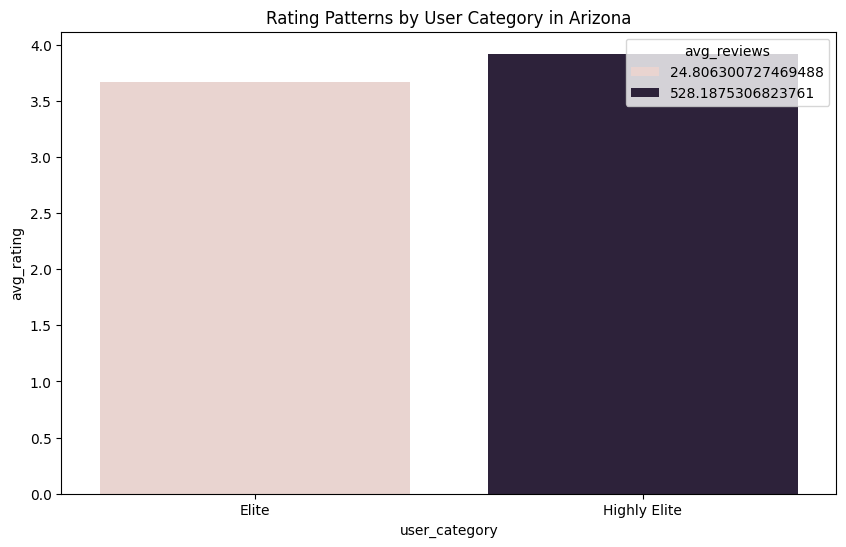

In [7]:
query2 = """
SELECT 
    CASE 
        WHEN elite != '[]' AND length(elite) > 20 THEN 'Highly Elite'
        WHEN elite != '[]' THEN 'Elite'
        ELSE 'Regular'
    END as user_category,
    COUNT(*) as user_count,
    AVG(review_count) as avg_reviews,
    AVG(average_stars) as avg_rating
FROM az_users
GROUP BY 1
ORDER BY user_count DESC
"""

result2 = spark.sql(query2)
result2_pd = result2.toPandas()

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=result2_pd, x='user_category', y='avg_rating', hue='avg_reviews')
plt.title('Rating Patterns by User Category in Arizona')
plt.show()

## Query 3 - User Experience Level Analysis

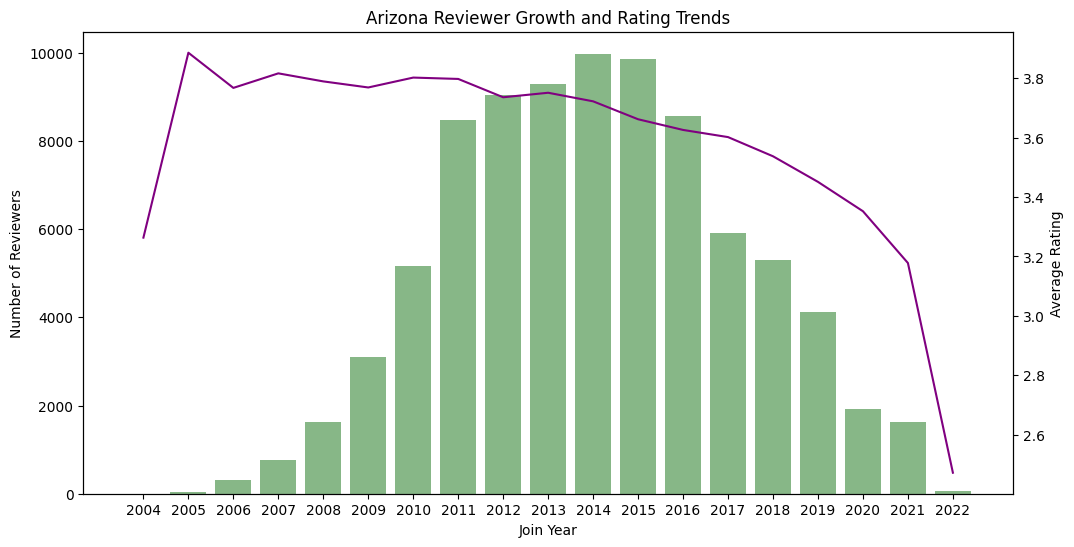

In [8]:
query3 = """
SELECT 
    SUBSTRING(yelping_since, 1, 4) as join_year,
    COUNT(*) as arizona_reviewers,
    AVG(review_count) as avg_reviews,
    AVG(average_stars) as avg_rating
FROM az_users
GROUP BY 1
ORDER BY 1
"""

result3 = spark.sql(query3)
result3_pd = result3.toPandas()

# Visualization
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

sns.barplot(data=result3_pd, x='join_year', y='arizona_reviewers', color='green', alpha=0.5, ax=ax1)
sns.lineplot(data=result3_pd, x='join_year', y='avg_rating', color='purple', ax=ax2)

ax1.set_title('Arizona Reviewer Growth and Rating Trends')
ax1.set_xlabel('Join Year')
ax1.set_ylabel('Number of Reviewers')
ax2.set_ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()

## Query 4 - User Engagement Analysis

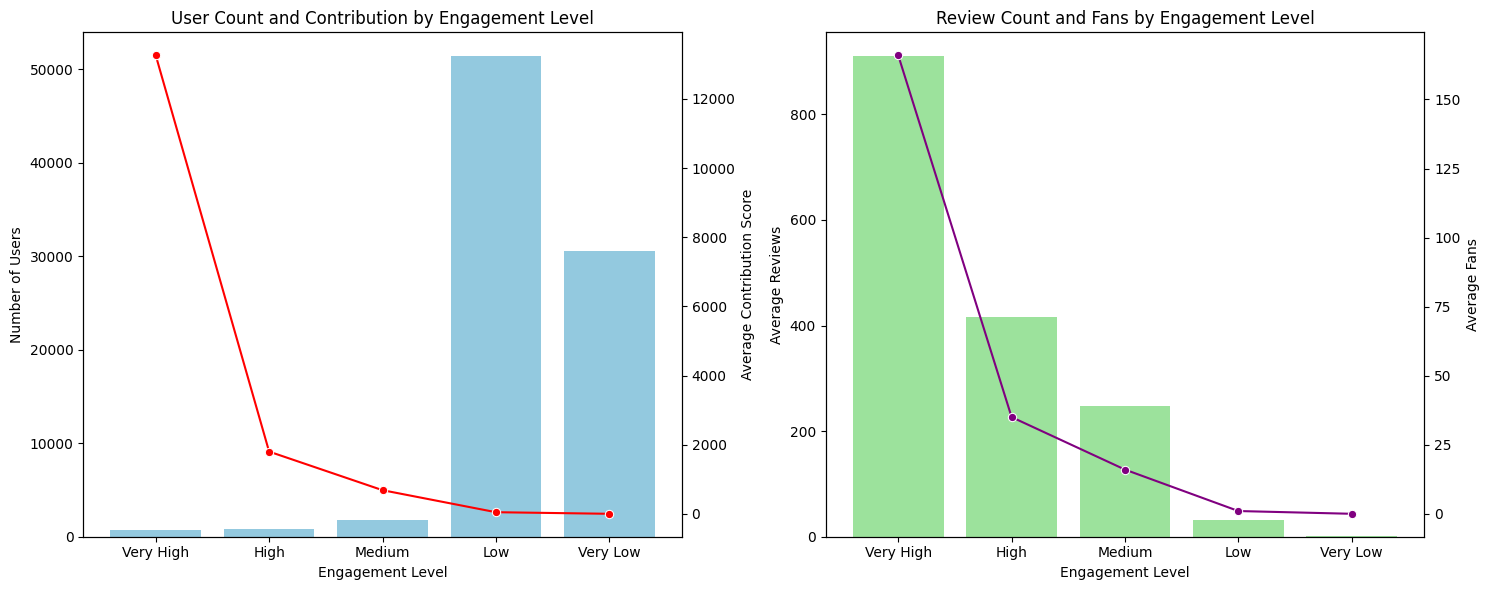

In [9]:
query4 = """
WITH user_engagement AS (
    SELECT 
        user_id,
        review_count,
        fans,
        useful + funny + cool as total_contribution,
        average_stars,
        CASE
            WHEN review_count >= 100 AND fans >= 50 THEN 'Very High'
            WHEN review_count >= 50 AND fans >= 25 THEN 'High'
            WHEN review_count >= 20 AND fans >= 10 THEN 'Medium'
            WHEN review_count >= 5 THEN 'Low'
            ELSE 'Very Low'
        END as engagement_level
    FROM az_users
)
SELECT 
    engagement_level,
    COUNT(*) as user_count,
    ROUND(AVG(average_stars), 2) as avg_rating,
    ROUND(AVG(total_contribution), 0) as avg_contribution,
    ROUND(AVG(review_count), 0) as avg_reviews,
    ROUND(AVG(fans), 0) as avg_fans
FROM user_engagement
GROUP BY engagement_level
ORDER BY 
    CASE engagement_level
        WHEN 'Very High' THEN 1
        WHEN 'High' THEN 2
        WHEN 'Medium' THEN 3
        WHEN 'Low' THEN 4
        WHEN 'Very Low' THEN 5
    END
"""

result4 = spark.sql(query4)
result4_pd = result4.toPandas()

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# First subplot: User count and average contribution
sns.barplot(data=result4_pd, x='engagement_level', y='user_count', ax=ax1, color='skyblue')
ax1_twin = ax1.twinx()
sns.lineplot(data=result4_pd, x='engagement_level', y='avg_contribution', ax=ax1_twin, color='red', marker='o')
ax1.set_title('User Count and Contribution by Engagement Level')
ax1.set_xlabel('Engagement Level')
ax1.set_ylabel('Number of Users')
ax1_twin.set_ylabel('Average Contribution Score')

# Second subplot: Average reviews and fans
sns.barplot(data=result4_pd, x='engagement_level', y='avg_reviews', ax=ax2, color='lightgreen')
ax2_twin = ax2.twinx()
sns.lineplot(data=result4_pd, x='engagement_level', y='avg_fans', ax=ax2_twin, color='purple', marker='o')
ax2.set_title('Review Count and Fans by Engagement Level')
ax2.set_xlabel('Engagement Level')
ax2.set_ylabel('Average Reviews')
ax2_twin.set_ylabel('Average Fans')

plt.tight_layout()
plt.show()

## Query 5 - User Review Analysis

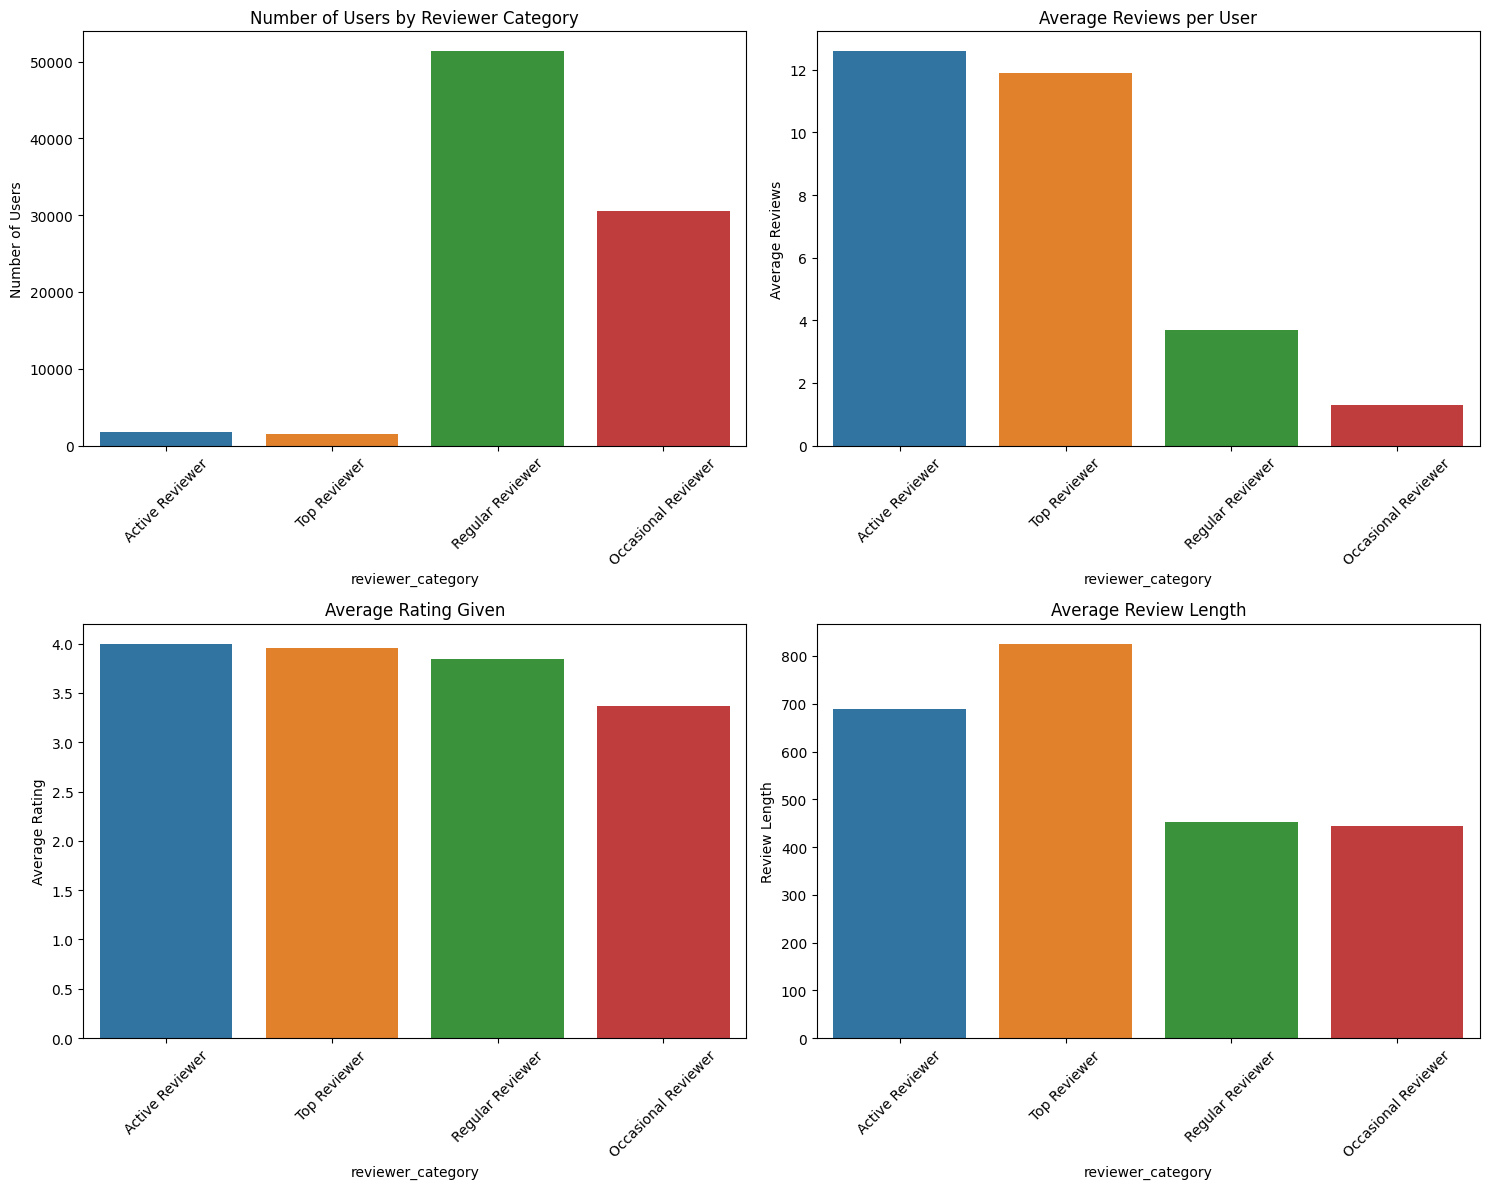

In [6]:
query5 = """
WITH user_review_metrics AS (
    SELECT 
        u.user_id,
        u.average_stars as user_avg_rating,
        COUNT(r.review_id) as review_count,
        AVG(r.stars) as avg_review_stars,
        AVG(LENGTH(r.text)) as avg_review_length,
        SUM(r.useful) as total_useful_votes,
        CASE
            WHEN u.review_count >= 50 AND u.fans >= 25 THEN 'Top Reviewer'
            WHEN u.review_count >= 20 AND u.fans >= 10 THEN 'Active Reviewer'
            WHEN u.review_count >= 5 THEN 'Regular Reviewer'
            ELSE 'Occasional Reviewer'
        END as reviewer_category
    FROM az_users u
    JOIN reviews r ON u.user_id = r.user_id
    JOIN business b ON r.business_id = b.business_id
    WHERE b.state = 'AZ' 
    AND b.categories LIKE '%Restaurants%'
    GROUP BY 
        u.user_id, 
        u.average_stars,
        u.review_count,
        u.fans
)
SELECT 
    reviewer_category,
    COUNT(*) as user_count,
    ROUND(AVG(review_count), 1) as avg_reviews_per_user,
    ROUND(AVG(avg_review_stars), 2) as avg_rating_given,
    ROUND(AVG(avg_review_length), 0) as avg_review_length,
    ROUND(AVG(total_useful_votes), 1) as avg_useful_votes
FROM user_review_metrics
GROUP BY reviewer_category
ORDER BY avg_reviews_per_user DESC
"""

result5 = spark.sql(query5)
result5_pd = result5.toPandas()

# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: User Count by Category
sns.barplot(data=result5_pd, x='reviewer_category', y='user_count', hue='reviewer_category', ax=ax1, legend=False)
ax1.set_title('Number of Users by Reviewer Category')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Number of Users')

# Plot 2: Average Reviews per User
sns.barplot(data=result5_pd, x='reviewer_category', y='avg_reviews_per_user', hue='reviewer_category', ax=ax2, legend=False)
ax2.set_title('Average Reviews per User')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylabel('Average Reviews')

# Plot 3: Average Rating Given
sns.barplot(data=result5_pd, x='reviewer_category', y='avg_rating_given', hue='reviewer_category', ax=ax3, legend=False)
ax3.set_title('Average Rating Given')
ax3.tick_params(axis='x', rotation=45)
ax3.set_ylabel('Average Rating')

# Plot 4: Average Review Length
sns.barplot(data=result5_pd, x='reviewer_category', y='avg_review_length', hue='reviewer_category', ax=ax4, legend=False)
ax4.set_title('Average Review Length')
ax4.tick_params(axis='x', rotation=45)
ax4.set_ylabel('Review Length')

plt.tight_layout()
plt.show()

## Query 6 - Seasonal Review Patterns

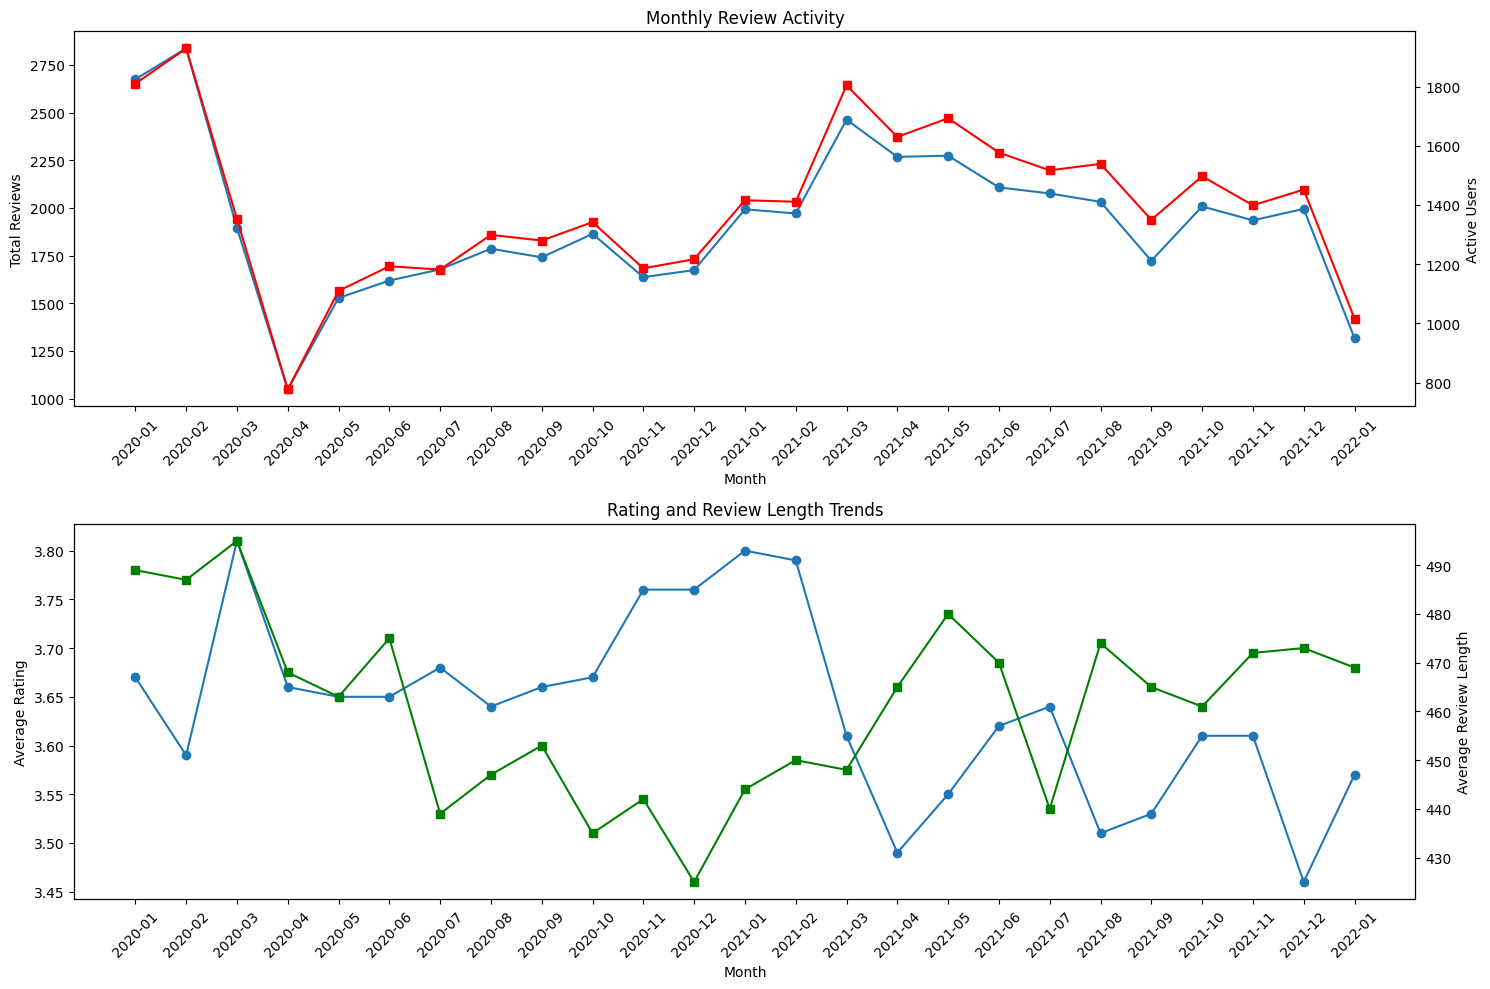

In [12]:
query6 = """
WITH monthly_patterns AS (
    SELECT 
        u.user_id,
        SUBSTRING(r.date, 1, 7) as review_month,
        COUNT(*) as reviews_count,
        AVG(r.stars) as avg_rating,
        AVG(LENGTH(r.text)) as avg_review_length
    FROM az_users u
    JOIN reviews r ON u.user_id = r.user_id
    JOIN business b ON r.business_id = b.business_id
    WHERE b.state = 'AZ' 
    AND b.categories LIKE '%Restaurants%'
    AND r.date >= '2020-01-01'
    GROUP BY u.user_id, SUBSTRING(r.date, 1, 7)
)
SELECT 
    review_month,
    COUNT(DISTINCT user_id) as active_users,
    SUM(reviews_count) as total_reviews,
    ROUND(AVG(avg_rating), 2) as average_rating,
    ROUND(AVG(avg_review_length), 0) as avg_review_length
FROM monthly_patterns
GROUP BY review_month
ORDER BY review_month
"""

result6 = spark.sql(query6)
result6_pd = result6.toPandas()

# Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot reviews and users
ax1.plot(result6_pd['review_month'], result6_pd['total_reviews'], marker='o', label='Total Reviews')
ax1_twin = ax1.twinx()
ax1_twin.plot(result6_pd['review_month'], result6_pd['active_users'], color='red', marker='s', label='Active Users')
ax1.set_title('Monthly Review Activity')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Reviews')
ax1_twin.set_ylabel('Active Users')
ax1.tick_params(axis='x', rotation=45)

# Plot average rating and review length
ax2.plot(result6_pd['review_month'], result6_pd['average_rating'], marker='o', label='Average Rating')
ax2_twin = ax2.twinx()
ax2_twin.plot(result6_pd['review_month'], result6_pd['avg_review_length'], color='green', marker='s', label='Avg Review Length')
ax2.set_title('Rating and Review Length Trends')
ax2.set_xlabel('Month')
ax2.set_ylabel('Average Rating')
ax2_twin.set_ylabel('Average Review Length')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Query 7 - User Rating Consistency Analysis

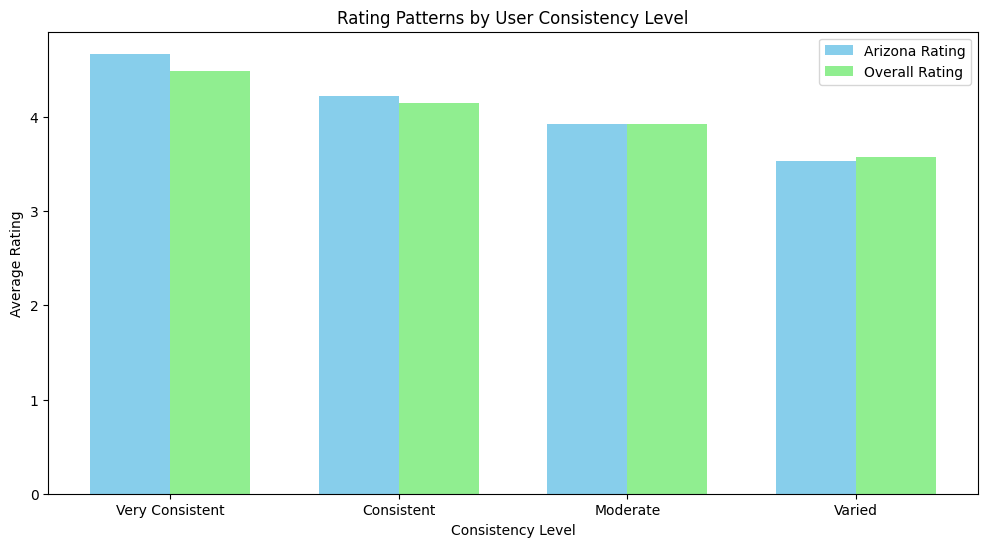

In [7]:
query7 = """
WITH user_rating_stats AS (
    SELECT 
        u.user_id,
        u.review_count,
        COUNT(r.review_id) as az_reviews,
        AVG(r.stars) as avg_az_rating,
        MAX(r.stars) - MIN(r.stars) as rating_range,
        u.average_stars as overall_avg_rating
    FROM az_users u
    JOIN reviews r ON u.user_id = r.user_id
    JOIN business b ON r.business_id = b.business_id
    WHERE b.state = 'AZ' 
    AND b.categories LIKE '%Restaurants%'
    GROUP BY u.user_id, u.review_count, u.average_stars
    HAVING COUNT(r.review_id) >= 10
)
SELECT 
    CASE 
        WHEN rating_range <= 1 THEN 'Very Consistent'
        WHEN rating_range <= 2 THEN 'Consistent'
        WHEN rating_range <= 3 THEN 'Moderate'
        ELSE 'Varied'
    END as consistency_level,
    COUNT(*) as user_count,
    ROUND(AVG(az_reviews), 0) as avg_reviews,
    ROUND(AVG(avg_az_rating), 2) as avg_rating_az,
    ROUND(AVG(overall_avg_rating), 2) as avg_rating_overall
FROM user_rating_stats
GROUP BY 1
ORDER BY 
    CASE consistency_level
        WHEN 'Very Consistent' THEN 1
        WHEN 'Consistent' THEN 2
        WHEN 'Moderate' THEN 3
        WHEN 'Varied' THEN 4
    END
"""

result7 = spark.sql(query7)
result7_pd = result7.toPandas()

# Visualization
plt.figure(figsize=(12, 6))
x = range(len(result7_pd['consistency_level']))
width = 0.35

plt.bar(x, result7_pd['avg_rating_az'], width, label='Arizona Rating', color='skyblue')
plt.bar([i + width for i in x], result7_pd['avg_rating_overall'], width, label='Overall Rating', color='lightgreen')

plt.xlabel('Consistency Level')
plt.ylabel('Average Rating')
plt.title('Rating Patterns by User Consistency Level')
plt.xticks([i + width/2 for i in x], result7_pd['consistency_level'])
plt.legend()
plt.show()

## Query 8 - Restaurant Category Preferences

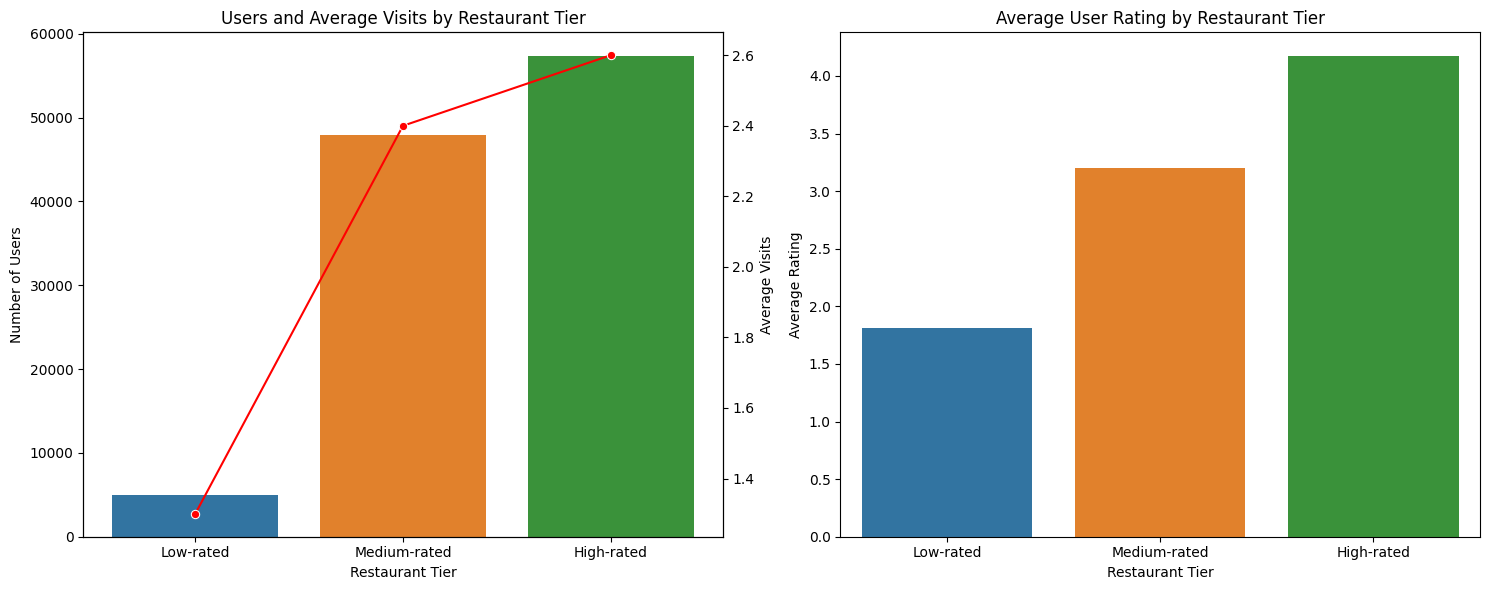

In [8]:
query8 = """
WITH user_category_preferences AS (
    SELECT 
        u.user_id,
        CASE 
            WHEN b.stars <= 2 THEN 'Low-rated'
            WHEN b.stars <= 3.5 THEN 'Medium-rated'
            ELSE 'High-rated'
        END as restaurant_tier,
        COUNT(*) as visit_count,
        AVG(r.stars) as avg_user_rating
    FROM az_users u
    JOIN reviews r ON u.user_id = r.user_id
    JOIN business b ON r.business_id = b.business_id
    WHERE b.state = 'AZ' 
    AND b.categories LIKE '%Restaurants%'
    GROUP BY u.user_id, 
        CASE 
            WHEN b.stars <= 2 THEN 'Low-rated'
            WHEN b.stars <= 3.5 THEN 'Medium-rated'
            ELSE 'High-rated'
        END
)
SELECT 
    restaurant_tier,
    COUNT(DISTINCT user_id) as unique_users,
    ROUND(AVG(visit_count), 1) as avg_visits,
    ROUND(AVG(avg_user_rating), 2) as avg_rating
FROM user_category_preferences
GROUP BY restaurant_tier
ORDER BY 
    CASE restaurant_tier
        WHEN 'Low-rated' THEN 1
        WHEN 'Medium-rated' THEN 2
        WHEN 'High-rated' THEN 3
    END
"""

result8 = spark.sql(query8)
result8_pd = result8.toPandas()

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Users and Visits by Restaurant Tier
sns.barplot(data=result8_pd, x='restaurant_tier', y='unique_users', hue='restaurant_tier', ax=ax1, legend=False)
ax1_twin = ax1.twinx()
sns.lineplot(data=result8_pd, x='restaurant_tier', y='avg_visits', ax=ax1_twin, color='red', marker='o')
ax1.set_title('Users and Average Visits by Restaurant Tier')
ax1.set_xlabel('Restaurant Tier')
ax1.set_ylabel('Number of Users')
ax1_twin.set_ylabel('Average Visits')

# Plot 2: Average Rating by Restaurant Tier
sns.barplot(data=result8_pd, x='restaurant_tier', y='avg_rating', hue='restaurant_tier', ax=ax2, legend=False)
ax2.set_title('Average User Rating by Restaurant Tier')
ax2.set_xlabel('Restaurant Tier')
ax2.set_ylabel('Average Rating')

plt.tight_layout()
plt.show()

## Query 9 - User Review Quality Analysis

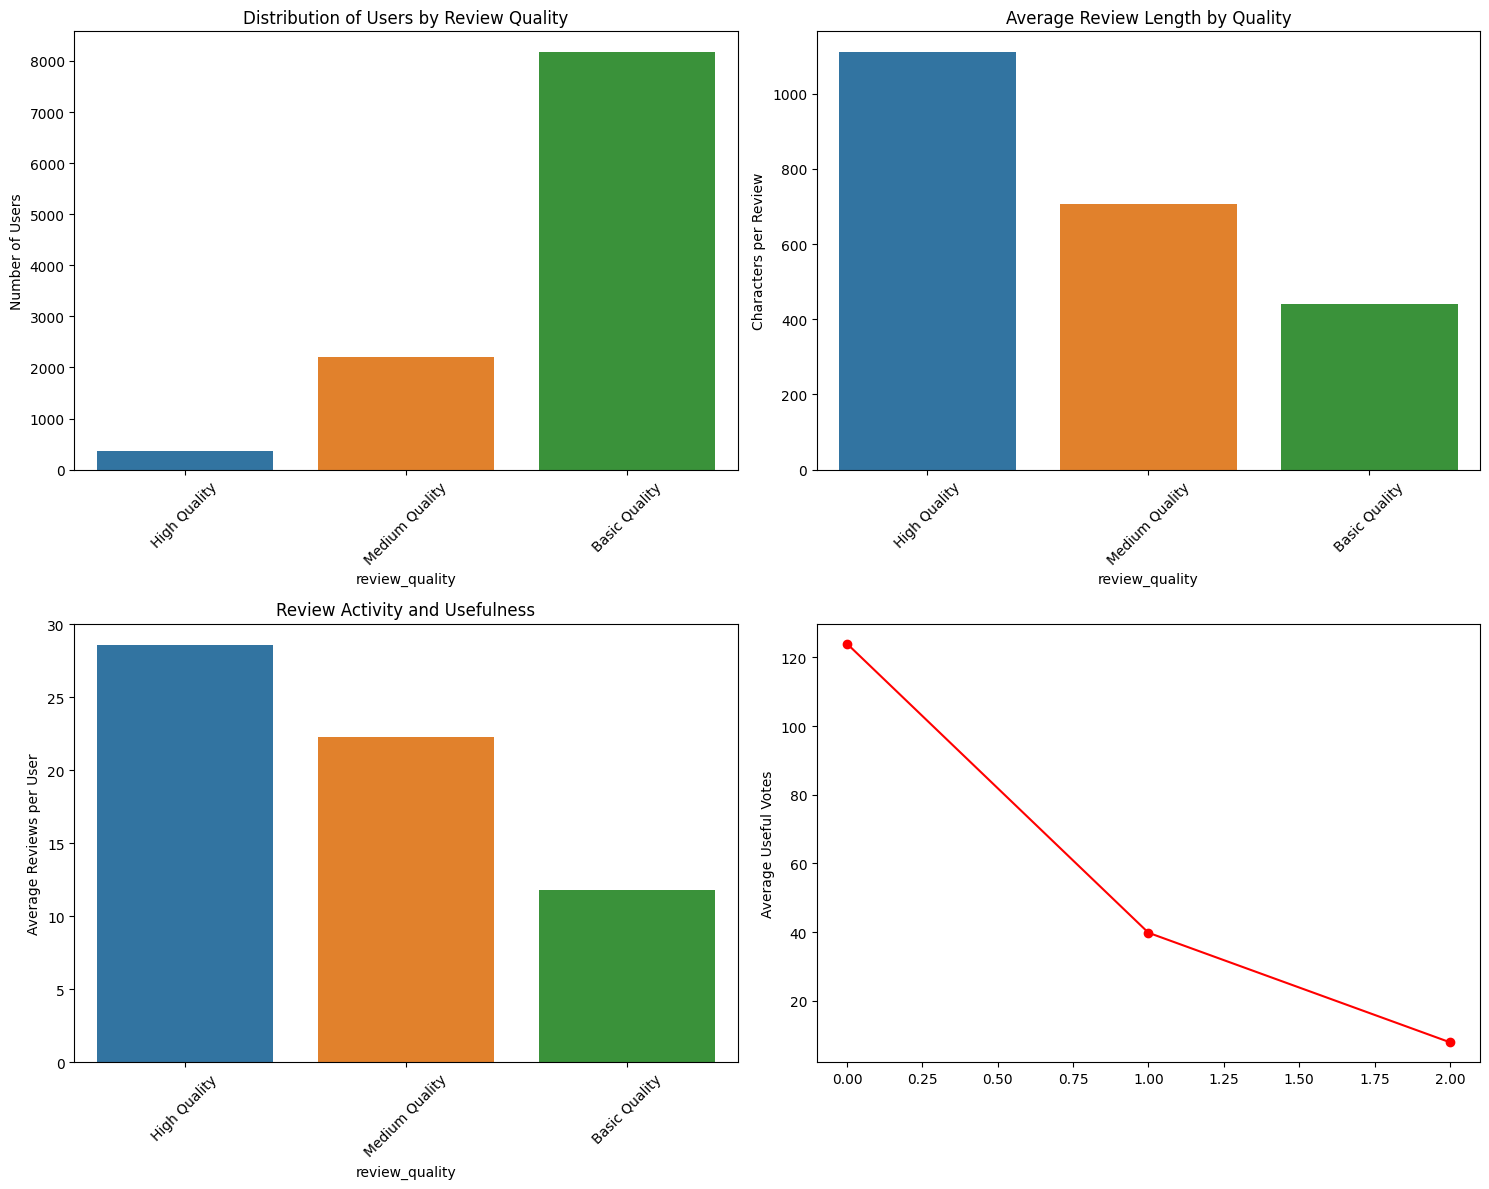

In [7]:
query9 = """
WITH review_metrics AS (
    SELECT 
        u.user_id,
        u.review_count,
        COUNT(r.review_id) as az_reviews,
        AVG(LENGTH(r.text)) as avg_review_length,
        AVG(r.useful + r.funny + r.cool) as avg_vote_score,
        SUM(r.useful) as total_useful_votes
    FROM az_users u
    JOIN reviews r ON u.user_id = r.user_id
    JOIN business b ON r.business_id = b.business_id
    WHERE b.state = 'AZ' 
    AND b.categories LIKE '%Restaurants%'
    GROUP BY u.user_id, u.review_count
    HAVING COUNT(r.review_id) >= 5
)
SELECT 
    CASE 
        WHEN avg_review_length > 500 AND avg_vote_score > 5 THEN 'High Quality'
        WHEN avg_review_length > 200 AND avg_vote_score > 2 THEN 'Medium Quality'
        ELSE 'Basic Quality'
    END as review_quality,
    COUNT(*) as user_count,
    ROUND(AVG(az_reviews), 1) as avg_reviews_per_user,
    ROUND(AVG(avg_review_length), 0) as avg_chars_per_review,
    ROUND(AVG(total_useful_votes), 1) as avg_useful_votes
FROM review_metrics
GROUP BY 1
ORDER BY avg_chars_per_review DESC
"""

result9 = spark.sql(query9)
result9_pd = result9.toPandas()

# Visualization
fig, ((ax1, ax2), (ax3, ax3_twin)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: User Distribution by Review Quality
sns.barplot(data=result9_pd, x='review_quality', y='user_count', hue='review_quality', ax=ax1, legend=False)
ax1.set_title('Distribution of Users by Review Quality')
ax1.set_ylabel('Number of Users')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Average Review Length by Quality
sns.barplot(data=result9_pd, x='review_quality', y='avg_chars_per_review', hue='review_quality', ax=ax2, legend=False)
ax2.set_title('Average Review Length by Quality')
ax2.set_ylabel('Characters per Review')
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Reviews and Useful Votes
bars = sns.barplot(data=result9_pd, x='review_quality', y='avg_reviews_per_user', hue='review_quality', ax=ax3, legend=False)
ax3.set_ylabel('Average Reviews per User')
line = ax3_twin.plot(range(len(result9_pd)), result9_pd['avg_useful_votes'], 'ro-', label='Avg Useful Votes')
ax3.set_title('Review Activity and Usefulness')
ax3_twin.set_ylabel('Average Useful Votes')
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Query 10 - User Geographic Impact Analysis

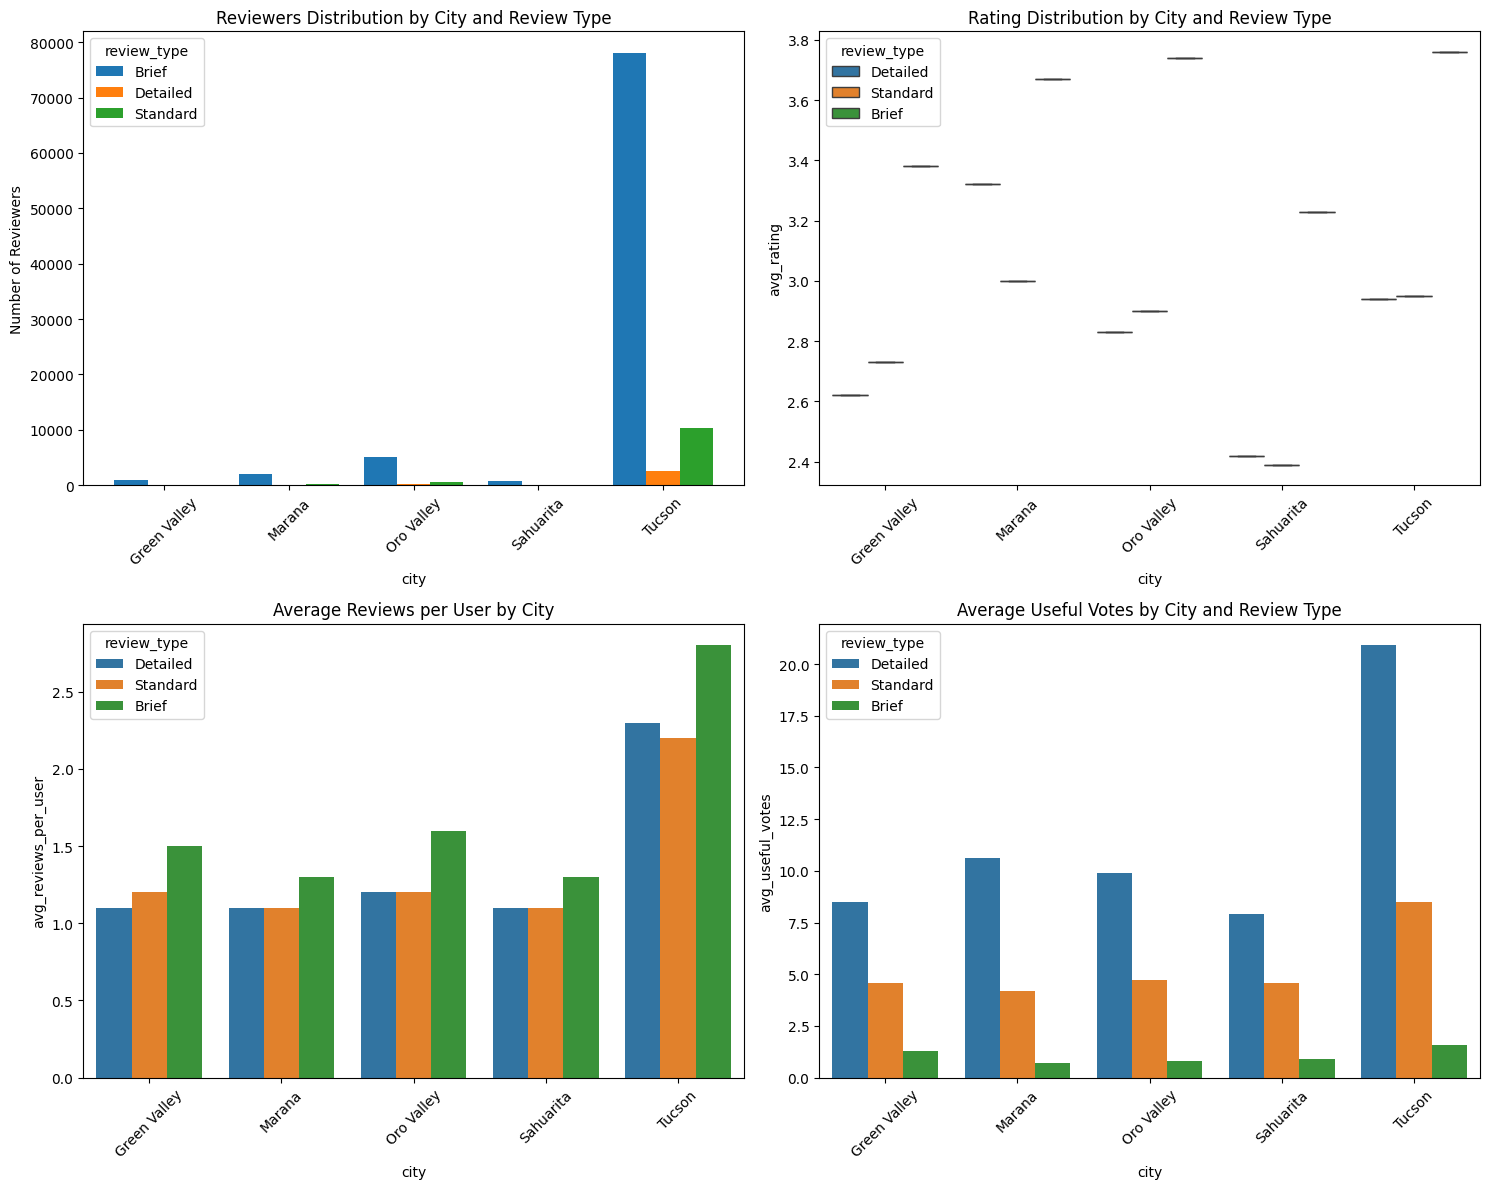

In [10]:
query10 = """
WITH user_city_impact AS (
    SELECT 
        u.user_id,
        b.city,
        COUNT(DISTINCT r.review_id) as review_count,
        AVG(r.stars) as avg_rating,
        AVG(LENGTH(r.text)) as avg_review_length,
        SUM(r.useful) as useful_votes,
        CASE 
            WHEN LENGTH(r.text) > 500 AND r.useful > 5 THEN 'Detailed'
            WHEN LENGTH(r.text) > 200 AND r.useful > 2 THEN 'Standard'
            ELSE 'Brief'
        END as review_type
    FROM az_users u
    JOIN reviews r ON u.user_id = r.user_id
    JOIN business b ON r.business_id = b.business_id
    WHERE b.state = 'AZ' 
    AND b.categories LIKE '%Restaurants%'
    GROUP BY 
        u.user_id, 
        b.city,
        CASE 
            WHEN LENGTH(r.text) > 500 AND r.useful > 5 THEN 'Detailed'
            WHEN LENGTH(r.text) > 200 AND r.useful > 2 THEN 'Standard'
            ELSE 'Brief'
        END
)
SELECT 
    city,
    review_type,
    COUNT(DISTINCT user_id) as unique_reviewers,
    ROUND(AVG(review_count), 1) as avg_reviews_per_user,
    ROUND(AVG(avg_rating), 2) as avg_rating,
    ROUND(AVG(useful_votes), 1) as avg_useful_votes
FROM user_city_impact
WHERE city IN (
    SELECT city 
    FROM (
        SELECT city, COUNT(*) as review_count
        FROM user_city_impact
        GROUP BY city
        ORDER BY review_count DESC
        LIMIT 5
    )
)
GROUP BY city, review_type
ORDER BY city, 
    CASE review_type
        WHEN 'Detailed' THEN 1
        WHEN 'Standard' THEN 2
        WHEN 'Brief' THEN 3
    END
"""

result10 = spark.sql(query10)
result10_pd = result10.toPandas()

# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Reviewers by City and Type
pivot_data = result10_pd.pivot(index='city', columns='review_type', values='unique_reviewers')
pivot_data.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title('Reviewers Distribution by City and Review Type')
ax1.set_ylabel('Number of Reviewers')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Average Rating by City and Type
sns.boxplot(data=result10_pd, x='city', y='avg_rating', hue='review_type', ax=ax2)
ax2.set_title('Rating Distribution by City and Review Type')
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Average Reviews per User
sns.barplot(data=result10_pd, x='city', y='avg_reviews_per_user', hue='review_type', ax=ax3)
ax3.set_title('Average Reviews per User by City')
ax3.tick_params(axis='x', rotation=45)

# Plot 4: Average Useful Votes
sns.barplot(data=result10_pd, x='city', y='avg_useful_votes', hue='review_type', ax=ax4)
ax4.set_title('Average Useful Votes by City and Review Type')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()